In [1]:
import urllib3
from urllib3 import request
import certifi
import json
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
#shouldn't be runned again, as it will reset already existing dataset
dota2DataFrame = pd.DataFrame(columns = ['match_id', 'duration','REFF@10', 'RCREEPS@10', 'DEFF@10', 'DCREEPS@10' ,'RGA@10', 'RXA@10', 'radiant_win'])

In [81]:
#loading already fetched data
dota2DataFrame = pd.read_csv('/content/sample_data/dota2ml.csv').drop('Unnamed: 0', axis=1)

In [3]:
http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())

In [82]:
url = 'https://api.opendota.com/api/parsedMatches'
r = http.request('GET', url)
print(r.status)
data = json.loads(r.data.decode('utf-8'))
df = pd.json_normalize(data)

200


In [83]:
for i in range(45):

  urltest = 'https://api.opendota.com/api/matches/%s' % df['match_id'][i]
  reff = 0.0
  deff = 0.0
  rCreeps = 0
  dCreeps = 0
  r = http.request('GET', urltest)
  ata = json.loads(r.data.decode('utf-8'))
  df2 = pd.json_normalize(ata)
  temp_df = pd.json_normalize(df2['players'][0])

  if df2['duration'][0] > 600:
    for k in range(10):
      if k <= 4:
        reff += temp_df['lane_efficiency_pct'][k]
        rCreeps += temp_df['lh_t'][k][10]
      else:
        deff += temp_df['lane_efficiency_pct'][k]
        dCreeps += temp_df['lh_t'][k][10]
    df2['radiant_gold_adv'] = df2['radiant_gold_adv'][0][10]
    df2['radiant_xp_adv'] = df2['radiant_xp_adv'][0][10]
    dota2DataFrame.loc[i+dota2DataFrame.shape[0]] = [df2['match_id'][0], df2['duration'][0], reff / 5, rCreeps, deff / 5, dCreeps, df2['radiant_gold_adv'][0], df2['radiant_xp_adv'][0], df2['radiant_win'][0]]


In [84]:
dota2DataFrame = dota2DataFrame.drop_duplicates().reset_index().drop('index', axis = 1)
dota2DataFrame

,match_id,duration,REFF@10,RCREEPS@10,DEFF@10,DCREEPS@10,RGA@10,RXA@10,radiant_win
0,6501224294,747,191.6,191,145.8,172,11394,8354,True
1,6501222069,738,54.0,82,56.8,81,-648,-156,False
2,6501220593,1002,138.4,116,83.0,62,13696,14366,True
3,6501219014,1138,112.2,120,128.8,149,-4122,-5053,True
4,6501218564,1101,170.8,150,121.0,103,12334,11041,True
...,...,...,...,...,...,...,...,...,...
943,6502273817,1428,57.8,154,57.8,118,58,1997,True
944,6502273523,1470,56.6,159,56.2,161,104,-1118,False
945,6502273269,876,148.6,224,108.0,128,10032,9236,True
946,6502272422,1072,143.4,133,99.0,87,10960,15226,True


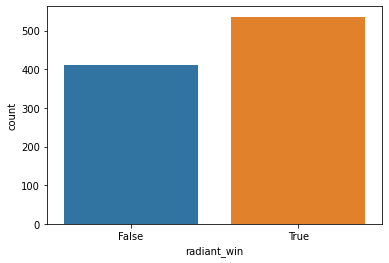

In [85]:
#Radiant win\loss
sn.countplot(x = 'radiant_win', data = dota2DataFrame)

In [86]:
X = dota2DataFrame[['REFF@10', 'RCREEPS@10', 'DEFF@10', 'DCREEPS@10' ,'RGA@10', 'RXA@10']]
y = dota2DataFrame['radiant_win'].replace(False, 0).replace(True, 1)

In [87]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state = 0)

In [88]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_log_pred_train = logistic_regression.predict(X_train)
y_log_pred_test = logistic_regression.predict(X_test)

In [89]:
print('Accuracy train: ',metrics.accuracy_score(y_train, y_log_pred_train))
print('train error: ',metrics.log_loss(y_train, y_log_pred_train))
print('Accuracy test: ',metrics.accuracy_score(y_test, y_log_pred_test))
print('test error: ',metrics.log_loss(y_test, y_log_pred_test))

Accuracy train:  0.7849604221635884
train error:  7.427300943712426
Accuracy test:  0.7578947368421053
test error:  8.362107924799608


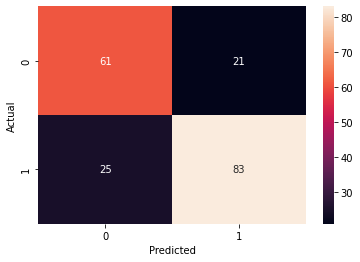

In [90]:
confusion_matrix = pd.crosstab(y_test, y_log_pred_test, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

In [91]:
from sklearn.neighbors import KNeighborsClassifier

In [92]:
dotaNeigh = KNeighborsClassifier(n_neighbors=5)
dotaNeigh.fit(X, y)
y_knn_pred_train = dotaNeigh.predict(X_train)
y_knn_pred_test = dotaNeigh.predict(X_test)

print('Accuracy train: ',metrics.accuracy_score(y_train, y_knn_pred_train))
print('train error: ',metrics.zero_one_loss(y_train, y_knn_pred_train))
print('Accuracy test: ',metrics.accuracy_score(y_test, y_knn_pred_test))
print('test error: ',metrics.zero_one_loss(y_test, y_knn_pred_test))

Accuracy train:  0.816622691292876
train error:  0.183377308707124
Accuracy test:  0.7631578947368421
test error:  0.23684210526315785


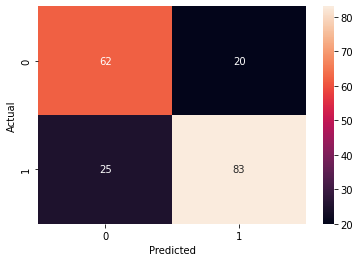

In [97]:
confusion_matrix = pd.crosstab(y_test, y_knn_pred_test, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

In [94]:
from sklearn.neural_network import MLPClassifier

In [98]:
mlp = MLPClassifier(hidden_layer_sizes=(125, 75, 25), max_iter=200 ,random_state=42)
mlp.fit(X, y)
y_mlp_pred_train = mlp.predict(X_train)
y_mlp_pred_test = mlp.predict(X_test)

print('Accuracy train: ',metrics.accuracy_score(y_train, y_mlp_pred_train))
print('train error: ',metrics.log_loss(y_train, y_mlp_pred_train))
print('Accuracy test: ',metrics.accuracy_score(y_test, y_mlp_pred_test))
print('test error: ',metrics.log_loss(y_test, y_mlp_pred_test))

Accuracy train:  0.7704485488126649
train error:  7.928528566840617
Accuracy test:  0.7842105263157895
test error:  7.453192756512484


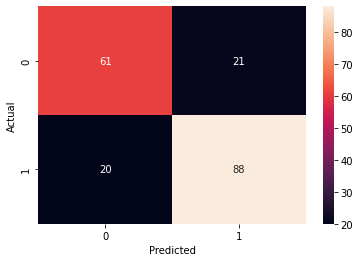

In [96]:
confusion_matrix = pd.crosstab(y_test, y_mlp_pred_test, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

In [ ]:
dota2DataFrame.to_csv()

',match_id,duration,REFF@10,RCREEPS@10,DEFF@10,DCREEPS@10,RGA@10,RXA@10,radiant_win\n0,6501224294,747,191.6,191,145.8,172,11394,8354,True\n1,6501222069,738,54.0,82,56.8,81,-648,-156,False\n2,6501220593,1002,138.4,116,83.0,62,13696,14366,True\n3,6501219014,1138,112.2,120,128.8,149,-4122,-5053,True\n4,6501218564,1101,170.8,150,121.0,103,12334,11041,True\n5,6501218052,1118,69.2,204,47.2,134,5421,4721,True\n6,6501217234,1137,144.6,105,109.8,87,8642,10052,True\n7,6501217083,1107,144.0,198,110.0,109,8350,10943,True\n8,6501216269,1319,136.2,164,146.8,147,-2572,-105,False\n9,6501216096,1225,154.4,202,135.2,173,4698,2972,True\n10,6501216073,976,112.8,87,120.6,148,-1920,-1033,False\n11,6501215830,1267,146.0,172,113.4,161,8044,9714,True\n12,6501215660,1198,110.4,135,144.2,155,-8406,-14301,False\n13,6501215466,1160,131.4,103,113.0,114,4528,6683,True\n14,6501215372,1110,146.8,174,127.2,102,4836,7102,True\n15,6501215297,1314,115.6,112,134.4,191,-4598,-6855,False\n16,6501215065,1223,67.2,154,51.2,135